In [1]:
import numpy as np
from qualtran.bloqs.chemistry.thc import SelectTHC, PrepareTHC

# Let's just generate some random coefficients for the moment with parameters
# corresponding to the FeMoCo model complex.
num_spin_orb = 108
num_mu = 350
num_bits_theta = 16
num_bits_state_prep = 10
tpq = np.random.normal(0, 1, size=(num_spin_orb//2, num_spin_orb//2))
zeta = np.random.normal(0, 1, size=(num_mu, num_mu))
zeta = 0.5 * (zeta + zeta.T)
eta = np.random.normal(0, 1, size=(num_mu, num_spin_orb//2))
eri_thc = np.einsum("Pp,Pr,Qq,Qs,PQ->prqs", eta, eta, eta, eta, zeta, optimize=True)
# In practice one typically uses the exact ERI tensor instead of that from THC, but that's a minor detail.
tpq_prime = tpq - 0.5 * np.einsum("illj->ij", eri_thc, optimize=True) + np.einsum("llij->ij", eri_thc, optimize=True)
t_l = np.linalg.eigvalsh(tpq_prime)
# Build Select and Prepare
prep_thc = PrepareTHC.from_hamiltonian_coeffs(t_l, eta, zeta, num_bits_state_prep=num_bits_state_prep)
sel_thc = SelectTHC(num_mu, num_spin_orb, num_bits_theta=num_bits_theta, keep_bitsize=prep_thc.keep_bitsize, kr1=16, kr2=16)

In [2]:
from qualtran.bloqs.block_encoding import LCUBlockEncoding
from qualtran.bloqs.multiplexers.black_box_select import BlackBoxSelect
from qualtran.bloqs.state_preparation.black_box_prepare import BlackBoxPrepare

epsilon = 1e-4  # choosing this arbitrarily at this point. See: https://github.com/quantumlib/Qualtran/issues/985
block_encoding_bloq = LCUBlockEncoding(
    select=BlackBoxSelect(sel_thc), prepare=BlackBoxPrepare(prep_thc)
)

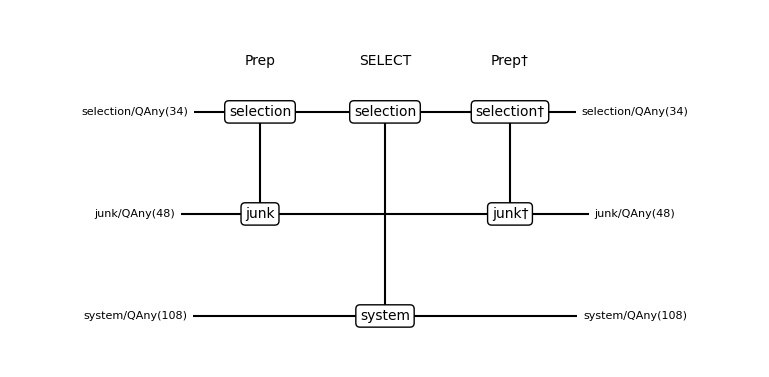

In [3]:
import matplotlib.pyplot as plt
from qualtran.drawing.musical_score import get_musical_score_data, draw_musical_score
msd = get_musical_score_data(block_encoding_bloq.decompose_bloq())
fig, ax = draw_musical_score(msd)
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
fig.set_size_inches(8, 4)

In [4]:
from qualtran.resource_counting import get_bloq_call_graph
import attrs
from qualtran.bloqs.bookkeeping import Partition, Split, Join, Allocate, Free
from qualtran.bloqs.basic_gates import CSwap, TGate
from qualtran.drawing import show_call_graph

def keeper(bloq):
    # intercept CSwaps which are lumped in with Toffolis in the reference papers
    if isinstance(bloq, CSwap):
        return True
    return False

def generalizer(bloq):
    if isinstance(bloq, (Partition, Split, Join, Allocate, Free)):
        return None
    return bloq


def get_toffoli_counts(bloq):
    _, sigma = get_bloq_call_graph(bloq, generalizer=generalizer, keep=keeper)
    toffolis = 0
    for k, v in sigma.items():
        if isinstance(k, CSwap):
            toffolis += v * k.bitsize
        elif isinstance(k, TGate):
            toffolis += v // 4
    return toffolis

num_toff = get_toffoli_counts(block_encoding_bloq)
# note the cost here is from openfermion, the reference number excludes the reflection
print(f'qualtran = {num_toff} vs. ref = 10880, delta = {num_toff - 10880}')

qualtran = 17894 vs. ref = 10880, delta = 7014
